In [1]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
tranform = transforms.ToTensor()  # Definindo a conversão de imagem para tensor

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=tranform)  # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=tranform)  # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)  # Cria um buffer para pegar os dados por partes

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\fabri/.pytorch/MNIST_data/MNIST\raw



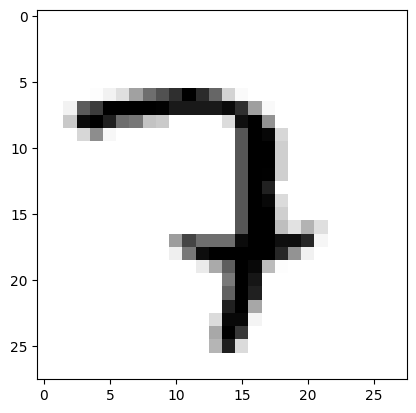

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [6]:
print(images[0].shape)  # Para verificar as dimensões do tensor de cada imagem
print(labels[0].shape)  # Para verificar as dimesões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [7]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.linear1 = nn.Linear(28*28, 128)  # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)     # Camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)      # Camada interna 2, 64 neurônios que se ligam a 10

    def forward(self, x):
        x = F.relu(self.linear1(x))  # A função de ativação da camada de entrada para a camada interna 1
        x = F.relu(self.linear2(x))  # A função de ativação da camada interna 1 para a camada interna 2
        x = self.linear3(x)          # A função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x

        return F.log_softmax(x, dim=1)  # Dados utilizados para calcular a perda

In [8]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)  # Define a política de atualização de pesos e da bias

    inicio = time()

    criterio = nn.NLLLoss()  # Definindo o critério para calcular a perda
    EPOCHS = 10  # Número de epochs para rodar

    modelo.train()  # Ativa o modo de trainamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1)  # Convertendo as imagens para vetores de 28*28 casas para ficarem compatíveis
            otimizador.zero_grad()  # Zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device))  # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device))  # Calculando a perda da epoch

            perda_instantanea.backward()  # Calculando os gradientes

            otimizador.step()  # Atualizando os pesos e bias

            perda_acumulada += perda_instantanea.item()  # Acumulando a perda

        print(f"Epoch {epoch+1} - Perda resultante: {perda_acumulada/len(trainloader)}")

    print(f"Demorou: {time() - inicio} segundo(s) para treinar.")

In [10]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0

    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)

            with torch.no_grad():
                logps = modelo(img.to(device))  # Output do modelo em escala logarítmica

            ps = torch.exp(logps)  # Output do modelo em escala normal
            probab = list(ps.cpu().numpy()[0])

            etiqueta_pred = probab.index(max(probab))  # Convertte o tensor em um número
            etiqueta_certa = etiquetas.numpy()[i]

            if(etiqueta_certa == etiqueta_pred):  # Compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print(f"Total de imagens testadas: {conta_todas}")
    print(f"Total de imagens corretas: {conta_corretas}")
    print(f"Porcentagem de acertos: {conta_corretas/conta_todas*100}%")

In [11]:
modelo = Model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
treino(modelo, trainloader, 'cpu')

Epoch 1 - Perda resultante: 1.2082523286088442
Epoch 2 - Perda resultante: 0.39160048019593713
Epoch 3 - Perda resultante: 0.31928741000195554
Epoch 4 - Perda resultante: 0.2793332885688683
Epoch 5 - Perda resultante: 0.24774460734001227
Epoch 6 - Perda resultante: 0.22171243474379912
Epoch 7 - Perda resultante: 0.19992600421685336
Epoch 8 - Perda resultante: 0.18180175699087095
Epoch 9 - Perda resultante: 0.1666570276117274
Epoch 10 - Perda resultante: 0.1534362808346494
Demorou: 271.3968245983124 segundo(s) para treinar.


In [13]:
validacao(modelo, valloader, 'cpu')

Total de imagens testadas: 10000
Total de imagens corretas: 9567
Porcentagem de acertos: 95.67%
